# Importar Bibliotecas

In [67]:
import pandas as pd
import os
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Função para facilitar QUERY

In [68]:
caminho_dados = os.path.join('../DADOS')
caminho_banco = os.path.join(caminho_dados, 'banco_Monitor_Inteligencia_HidroFinanceira_SetorEletrico.db')

def executar_query(sql):
    with sqlite3.connect(caminho_banco) as conexao:
        return pd.read_sql(sql, conexao, parse_dates='ear_data')

# Leitura das tabelas

In [77]:
# Sudeste filtrado por conta de 70% de toda o armazenamento está lá, além da maior parte do consumo. Obtendo já um bom reflexo do todo.
df_ear_mensal = executar_query('''
    SELECT
        strftime('%Y-%m', ear_data) as ano_mes,
        nom_subsistema as estado,
        AVG(ear_verif_subsistema_percentual) as ear_medio_mensal
    FROM tb_ear_ons
    WHERE nom_subsistema = 'SUDESTE'
    GROUP BY ano_mes
    ORDER BY ano_mes
''')

In [78]:
df_pld_mensal = executar_query('''
    SELECT
        strftime('%Y-%m',DATA_FIM) as ano_mes,
        AVG(SUDESTE) as SUDESTE
    FROM tb_pld_semanal                  
    GROUP BY ano_mes
    ORDER BY ano_mes

''')

# Transformar as colunas de regiões em linhas
df_pld_mensal = df_pld_mensal.melt(
    id_vars=['ano_mes'], # Coluna que não muda
    var_name='estado',
    value_name='pld_medio_mensal'
)

In [79]:
df_total = pd.merge(
    df_pld_mensal,
    df_ear_mensal,
    on=['ano_mes', 'estado'],
    how='inner'
)

if not df_total.empty:
    with sqlite3.connect(caminho_banco) as conn:
        df_total.to_sql('tb_cenario_macro', conn, if_exists='replace', index=False)
        print(f"✅ Tabela 'tb_cenario_macro' salva !")
else:
    print("⚠️ Erro ao Salvar 'tb_cenario_macro' no banco de dados")

df_total

✅ Tabela 'tb_cenario_macro' salva !


,ano_mes,estado,pld_medio_mensal,ear_medio_mensal
0,2001-07,SUDESTE,684.0000,27.750968
1,2001-08,SUDESTE,684.0000,25.178710
2,2001-09,SUDESTE,597.0000,21.898000
3,2001-10,SUDESTE,336.0000,21.279677
4,2001-11,SUDESTE,336.0000,21.422667
...,...,...,...,...
286,2025-05,SUDESTE,214.5680,69.704706
287,2025-06,SUDESTE,242.2575,67.380117
288,2025-07,SUDESTE,190.9575,64.916748
289,2025-08,SUDESTE,289.5480,60.487787


# Visualização

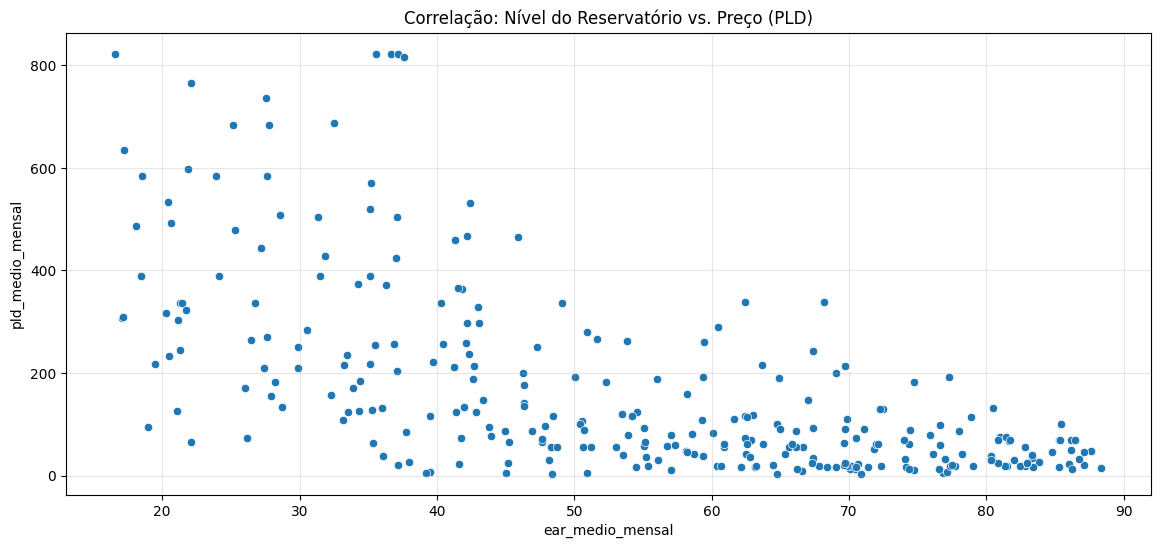

In [84]:
plt.figure(figsize=(14, 6))

# Plotando o PLD
sns.scatterplot(data=df_total, x='ear_medio_mensal', y='pld_medio_mensal')
plt.title('Correlação: Nível do Reservatório vs. Preço (PLD)')
plt.grid(True, alpha=0.3)
plt.show()